In [17]:
!ls

fashion-mnist_test.csv  fashion.ipynb           t10k-labels-idx1-ubyte
fashion-mnist_train.csv t10k-images-idx3-ubyte


In [23]:
#IMPORTS
import pandas as pd
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [15]:
#LOAD CSV DATA
tr_filename = 'fashion-mnist_train.csv'
tr = pd.read_csv(tr_filename)

In [18]:
#LOAD IMAGE DATA
f = 't10k-images-idx3-ubyte'
l = 't10k-labels-idx1-ubyte'
imagearray = idx2numpy.convert_from_file(f)
labels = idx2numpy.convert_from_file(l)


(10000, 28, 28)
Bag
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   6   0   0   0   0
    8   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   2   0   0  25  95  89   0
    0   2   1   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0   0 144 214 174 179 209
   83   0   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   7   0 144 184   0   0   0  46
  205  62   0   4   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0  65 200   0   0   0   0   0
   64 173   0   5   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  11   0 140  86   0   2   0   0   0
    0 160  52   0   4   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 163   0   0   0   0   0   2
    0 116  91   0   9   0   0   0   0   0]
 [  0   0   0   1   5   4   4   3   3   0   0 164   0   0   1   2   2   7
    0 108 143   0   3   0   1   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   

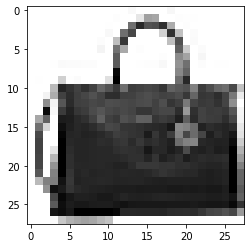

In [32]:
plt.imshow(imagearray[30], cmap=plt.cm.binary)
print(imagearray.shape)
print(label_map[labels[30]])
print(imagearray[30])

In [28]:
#Preprocessing
class Normalize:
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit(self, X):
        self.mean = np.mean(X)
        self.std = np.std(X)
        
    def normalize(self, X):
        X -= self.mean
        X /= self.std
        return X

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
